In [1]:
import sqlite3
from sqlite3 import Error

import pandas as pd
from IPython.display import Image

pd.options.mode.chained_assignment = None

In [2]:
def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def insert_sql_statement(insert_data, conn, table_name):
    with conn:
        cur = conn.cursor()

        empty_value_container = "?,"*len(insert_data[0])
        empty_value_container = "".join(["(",empty_value_container.strip(","),")"])

        cur.executemany(f"INSERT INTO {table_name} VALUES {empty_value_container}", insert_data)
        
def read_sql_query(query, conn):
    result = pd.read_sql_query(query, conn)
    return result

In [3]:
# Open Formule1 Database
database_filename = './data/f1_info.db'
conn = create_connection(database_filename, delete_db=False)

In [4]:
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings('ignore')

In [5]:
query_statement = """
                select year, constructors.name from constructor_standings
                
                    join

                        (
                        
                            select year, raceId from races
                            group by year
                            having max(round)
                        
                        ) as last_race

                            on last_race.raceId = constructor_standings.raceId
                        
                    join constructors
                        on constructor_standings.constructorId=constructors.constructorId
                
                where position=1
                
                order by year
            """
result = read_sql_query(query_statement, conn)

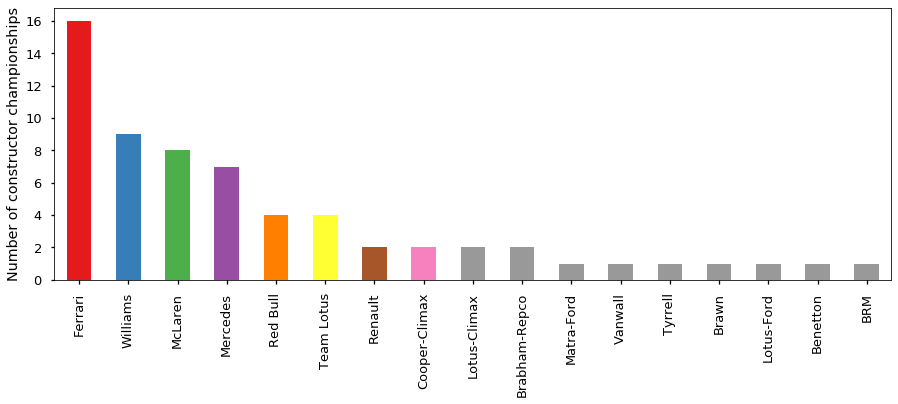

In [6]:
fig, ax = plt.subplots(figsize=(15,5))

cmap = plt.get_cmap('Set1')
colors=[cmap(i) for i in range(len(result.name.unique()))]

result.name.value_counts().plot.bar(ax=ax, color=colors)
ax.set_ylabel("Number of constructor championships")
ax.grid(False);

In [7]:
result[(result.year>=2010) & (result.year<2020)]

,year,name
52,2010,Red Bull
53,2011,Red Bull
54,2012,Red Bull
55,2013,Red Bull
56,2014,Mercedes
57,2015,Mercedes
58,2016,Mercedes
59,2017,Mercedes
60,2018,Mercedes
61,2019,Mercedes


In [8]:
query_statement = """
                select last_race.year, constructors.name, position from constructor_standings
                
                    join

                        (
                        
                            select year, raceId from races
                            where year between 2010 and 2019
                            group by year
                            having max(round)
                        
                        ) as last_race

                            on constructor_standings.raceId = last_race.raceId
                    
                    join constructors
                        on constructors.constructorId = constructor_standings.constructorId
                
                where constructors.name = "Ferrari"
                
                order by last_race.year
            """
result = read_sql_query(query_statement, conn)

In [9]:
result

,year,name,position
0,2010,Ferrari,3
1,2011,Ferrari,3
2,2012,Ferrari,2
3,2013,Ferrari,3
4,2014,Ferrari,4
5,2015,Ferrari,2
6,2016,Ferrari,3
7,2017,Ferrari,2
8,2018,Ferrari,2
9,2019,Ferrari,2


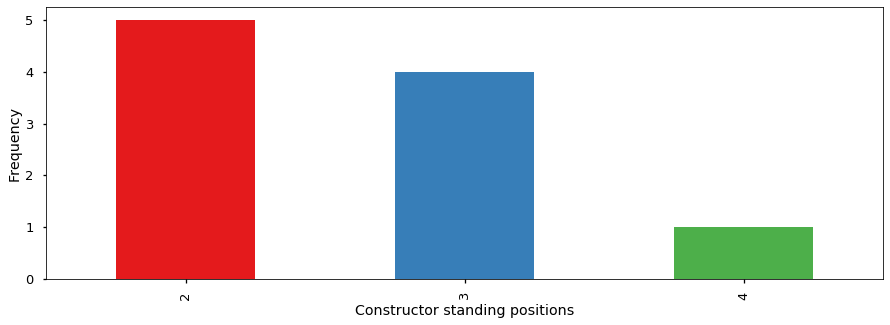

In [10]:
fig, ax = plt.subplots(figsize=(15,5))

cmap = plt.get_cmap('Set1')
colors=[cmap(i) for i in range(len(result.position.unique()))]

result.position.value_counts().plot.bar(ax=ax, color=colors)
ax.grid(False)
ax.set_ylabel("Frequency")
ax.set_xlabel("Constructor standing positions");

In [11]:
query_statement = """
                select last_race.year, constructors.name, constructor_standings.position, constructor_standings.points from constructor_standings
                
                    join

                        (
                        
                            select year, raceId from races
                            where year between 2010 and 2019
                            group by year
                            having max(round)
                        
                        ) as last_race

                            on last_race.raceId = constructor_standings.raceId
                        
                    join constructors
                        on constructors.constructorId = constructor_standings.constructorId
                
                where constructors.name = "Ferrari" or constructor_standings.position = 1
                
                order by year, position
            """
result = read_sql_query(query_statement, conn)

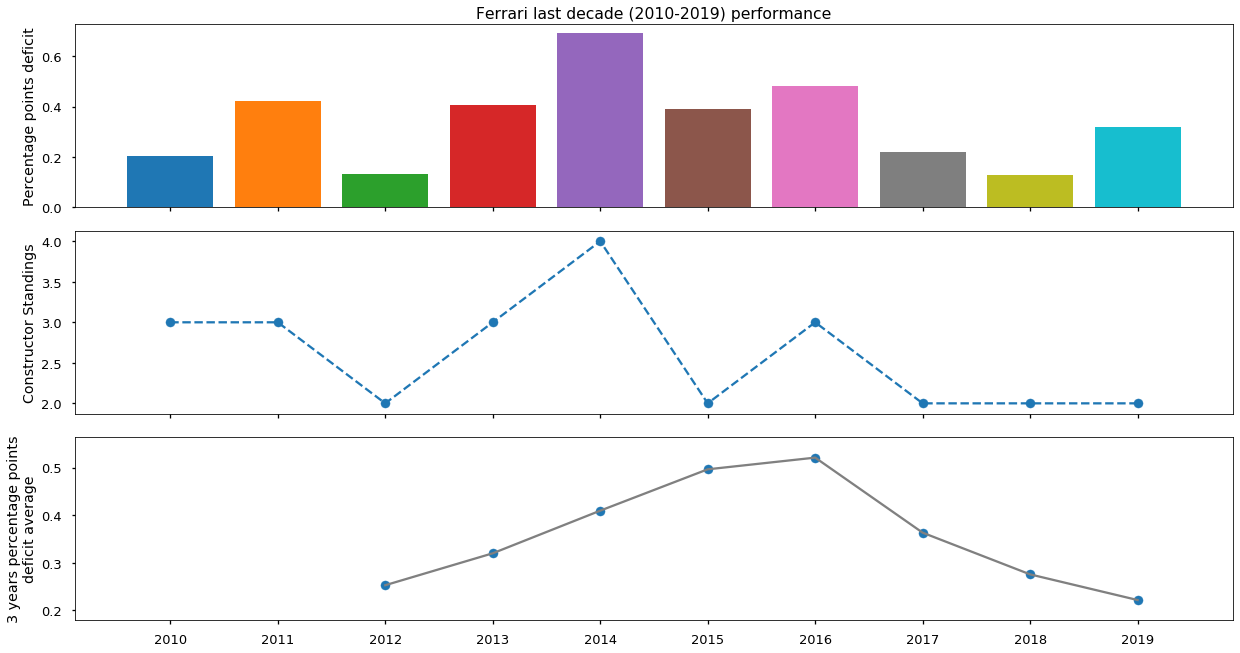

In [12]:
# Calculate Ferrari's percentage deficit over the decade
percent_deficit = []
years = result.year.unique()
for year in years:
    percent_deficit.append(-1*(result[result.year==year].points.pct_change().iloc[1]))
    

# Calculate moving average
numbers = percent_deficit.copy()
window_size = 3
i = 0
moving_averages = []

while i < len(numbers) - window_size + 1:
    this_window = numbers[i : i + window_size]
    window_average = sum(this_window) / window_size
    moving_averages.append(window_average)
    i += 1

fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, figsize=(17,9), sharex=True)
fig.tight_layout()

cmap = plt.get_cmap('tab10')
colors=[cmap(i) for i in range(len(result.year.unique()))]

ax1.bar(years, percent_deficit, color=colors)
ax1.grid(False)

ax2.scatter(years, result[result.name=="Ferrari"].position.values)
ax2.plot(years, result[result.name=="Ferrari"].position.values, linestyle="--")
ax2.grid(False)

ax3.scatter(years[2:], moving_averages)
ax3.plot(years[2:], moving_averages, c="gray", label="3-years moving average")
ax3.grid(False)

ax1.set_ylabel("Percentage points deficit")
ax2.set_ylabel("Constructor Standings")
ax3.set_ylabel("3 years percentage points\ndeficit average")

ax1.set_title("Ferrari last decade (2010-2019) performance")
ax3.set_xticks(years)
ax3.set_xticklabels(years, fontsize=13);

In [13]:
query_statement = """
                select races.year, races.round, constructors.name, constructor_standings.points, season_winner.seasonWinner from races
                
                join
                
                    (
                    
                        select last_race.year, constructors.name as seasonWinner from constructor_standings

                        join

                            (

                                select year, raceId from races
                                where year between 2010 and 2019
                                group by year
                                having max(round)

                            ) as last_race

                                on constructor_standings.raceId = last_race.raceId

                        join constructors
                            on constructors.constructorId = constructor_standings.constructorId

                        where constructor_standings.position=1
                    
                    ) as season_winner
                    
                        on races.year = season_winner.year
                
                join constructor_standings
                    on constructor_standings.raceId = races.raceId
                    
                join constructors
                    on constructors.constructorId = constructor_standings.constructorId
                    
                where constructors.name = "Ferrari" or constructors.name = season_winner.seasonWinner
                    
                order by races.year, races.round, constructor_standings.position
            """
result = read_sql_query(query_statement, conn)

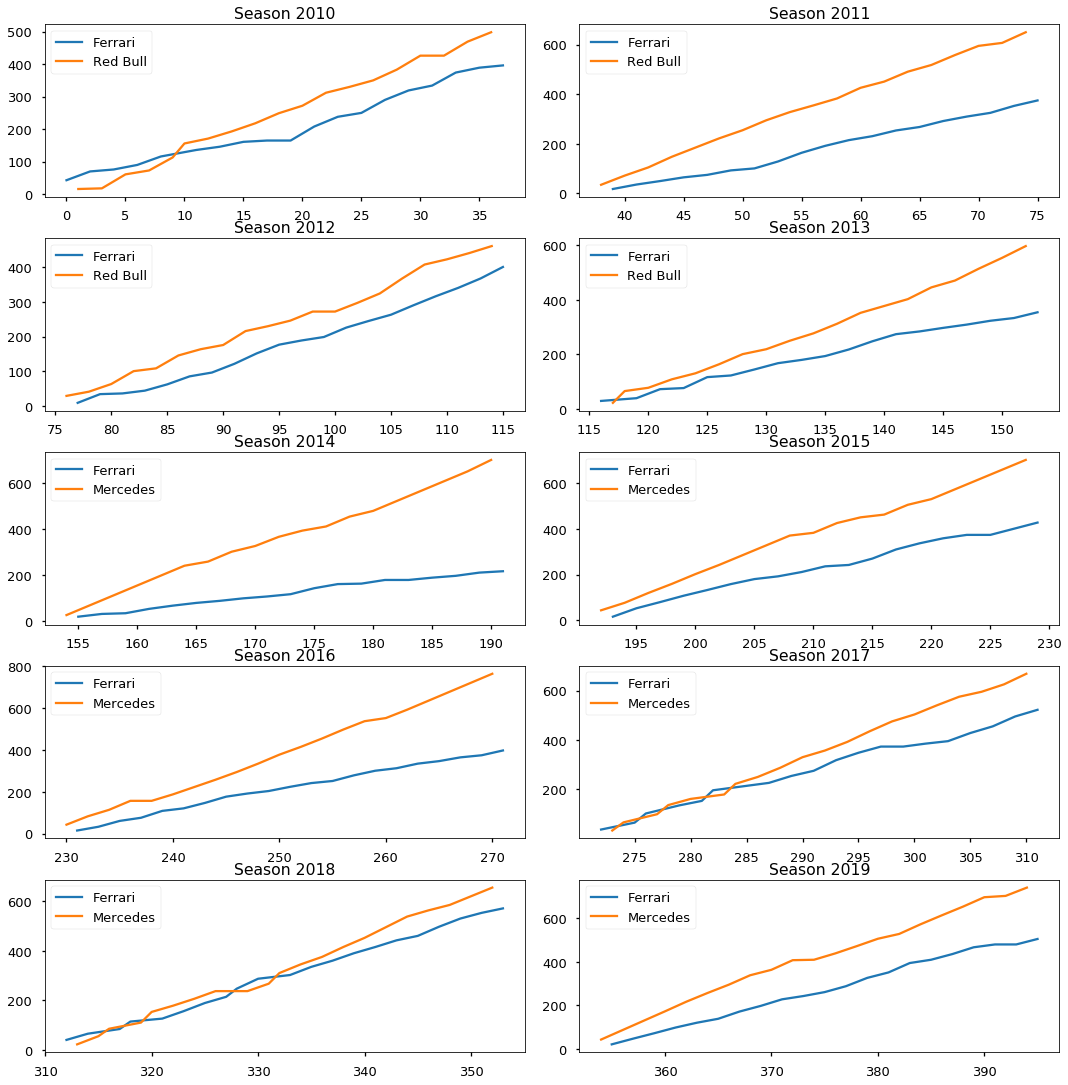

In [14]:
fig, ax = plt.subplots(figsize=(15,15), nrows=5, ncols=2)
fig.tight_layout()
years = result.year.unique()
for ind in range(0,len(years),2):
    ax_ind = ind//2
    result[result.year==years[ind]].groupby("name")["points"].plot(x="round", y="points", legend=True, ax=ax[ax_ind][0])
    result[result.year==years[ind+1]].groupby("name")["points"].plot(x="round", y="points", legend=True, ax=ax[ax_ind][1])
    
    ax[ax_ind][0].set_title(f"Season {years[ind]}")
    ax[ax_ind][1].set_title(f"Season {years[ind+1]}")
    
    ax[ax_ind][0].grid(False)
    ax[ax_ind][1].grid(False);

In [15]:
query_statement = """
                select races.year, constructors.name,
                
                    (
                        case
                            when results.position<=3 then "Podium"
                            when results.position between 4 and 10 then "In points"
                            else
                                case
                                    when status.status like "Finish%" or status.status like "+%" then "Out of points"
                                    else "DNF"
                                end 
                        end
                    ) as "resultType"
                
                from results
                
                join races
                    on races.raceId = results.raceId
                    
                join constructors
                    on constructors.constructorId = results.constructorId
                    
                join status
                    on results.statusId = status.statusId
                    
                join
                
                    (
                    
                        select last_race.year, constructors.name as seasonWinner from constructor_standings

                        join

                            (

                                select year, raceId from races
                                where year between 2010 and 2019
                                group by year
                                having max(round)

                            ) as last_race

                                on constructor_standings.raceId = last_race.raceId

                        join constructors
                            on constructors.constructorId = constructor_standings.constructorId

                        where constructor_standings.position=1

                    
                    ) as season_winner
                    
                on season_winner.year = races.year
                
                where constructors.name = "Ferrari" or constructors.name = season_winner.seasonWinner
            """
result = read_sql_query(query_statement, conn)

In [16]:
result

,year,name,resultType
0,2010,Ferrari,Podium
1,2010,Ferrari,Podium
2,2010,Red Bull,In points
3,2010,Red Bull,In points
4,2010,Ferrari,Podium
...,...,...,...
787,2019,Mercedes,DNF
788,2019,Mercedes,Podium
789,2019,Ferrari,Podium
790,2019,Mercedes,In points


In [17]:
pd.show_versions()


INSTALLED VERSIONS
------------------
commit           : db08276bc116c438d3fdee492026f8223584c477
python           : 3.7.6.final.0
python-bits      : 64
OS               : Linux
OS-release       : 5.4.17-2036.102.0.2.el7uek.x86_64
Version          : #2 SMP Tue Jan 5 12:41:34 PST 2021
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : None
LANG             : en_US.UTF-8
LOCALE           : en_US.UTF-8

pandas           : 1.1.3
numpy            : 1.18.1
pytz             : 2019.3
dateutil         : 2.8.1
pip              : 20.0.2
setuptools       : 45.2.0.post20200210
Cython           : 0.29.15
pytest           : 5.3.5
hypothesis       : 5.5.4
sphinx           : 2.4.0
blosc            : None
feather          : None
xlsxwriter       : 1.2.7
lxml.etree       : 4.5.0
html5lib         : 1.0.1
pymysql          : None
psycopg2         : None
jinja2           : 2.11.1
IPython          : 7.12.0
pandas_datareader: None
bs4              : 4.8.2
bottlene

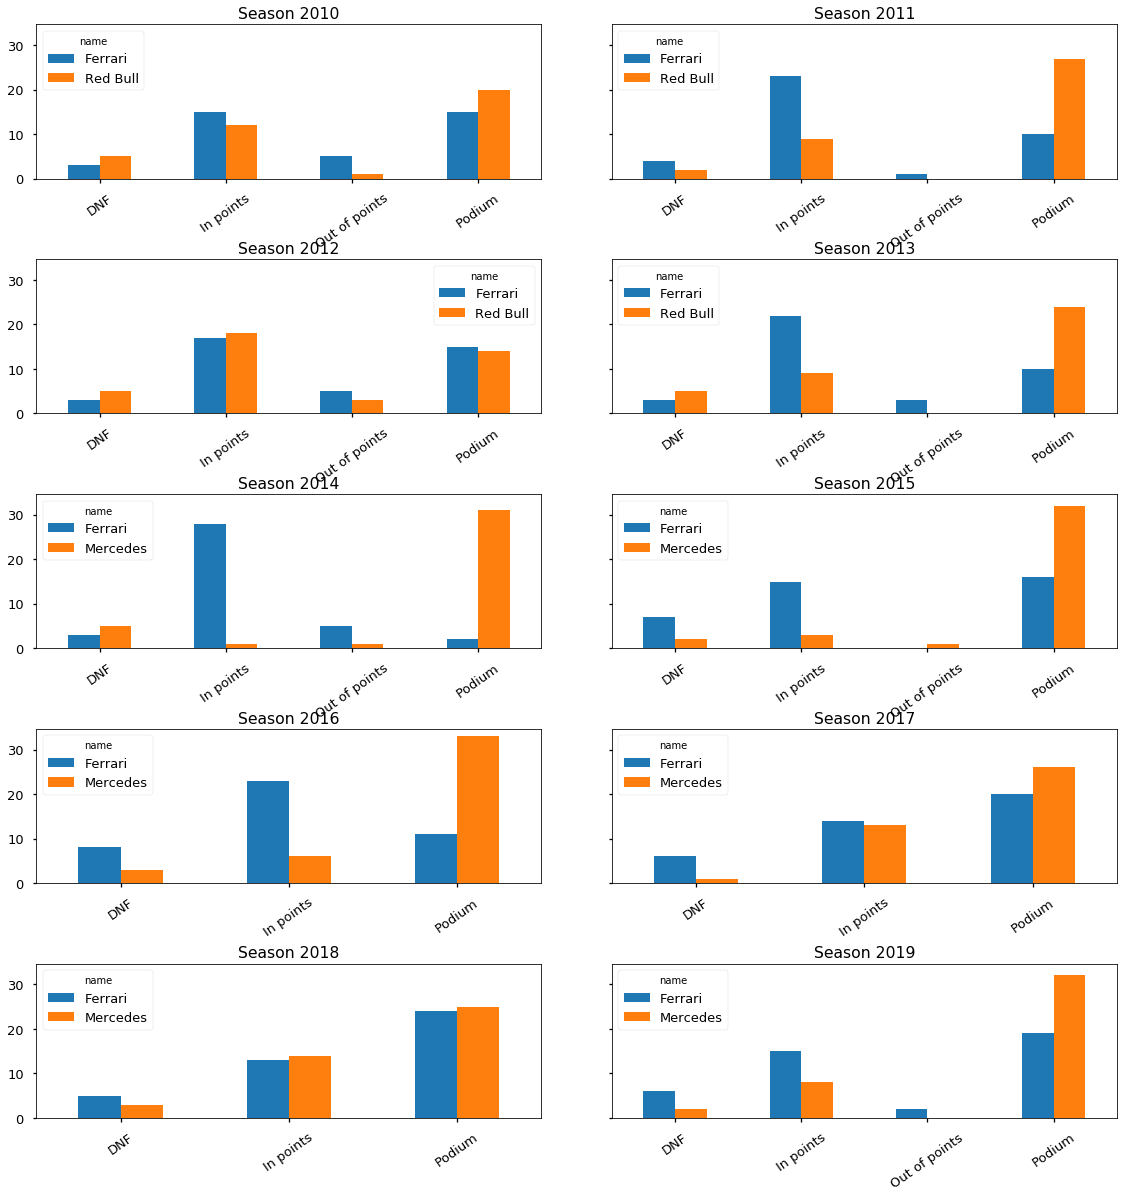

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(17,17), nrows=5, ncols=2, sharey=True)
fig.tight_layout(pad=5)
years = result.year.unique()
for ind in range(0,len(years),2):
    ax_ind = ind//2
    
    for add in range(2):
        year = years[ind+add]
        df = result[result.year==year].groupby("name").resultType.value_counts().to_frame()
        name = []
        resultType = []
        for team, cat in df.index:
            name.append(team)
            resultType.append(cat)
        df.index = range(df.shape[0])
        df.rename(columns={"resultType":"Counts"}, inplace=True)
        df["name"] = name
        df["resultType"] = resultType
        df.pivot(index='resultType', columns='name', values='Counts').plot(kind='bar', ax=ax[ax_ind][add], rot=35, xlabel="")
        ax[ax_ind][add].set_title(f"Season {years[ind+add]}")
        ax[ax_ind][add].grid(False);

In [19]:
query_statement = """
                select 
                
                    (

                        case
                            when races.year<2015 then "2010-2014"
                            else "2015-2019"
                        end

                    ) as "yearPartition",
                
                    (

                        case
                            when status.status like "Finish%" or status.status like "+%" then "Completed"
                            else status.status
                        end

                    ) as resultType
                
                from results
                
                join races
                    on races.raceId = results.raceId
                    
                join constructors
                    on constructors.constructorId = results.constructorId
                    
                join status
                    on status.statusId = results.statusId
                    
                where races.year between 2010 and 2019 and constructors.name = "Ferrari"
                
            """
result = read_sql_query(query_statement, conn)

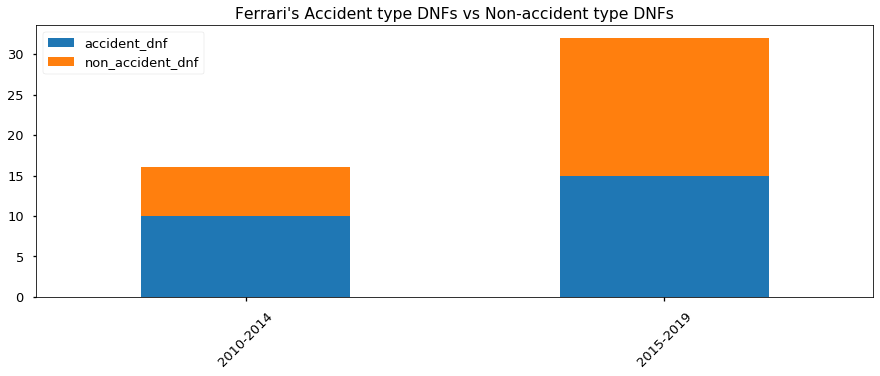

In [20]:
df = result[result.resultType!="Completed"].groupby("yearPartition").resultType.value_counts(sort=True, ascending=True).to_frame()
yearPartition = []
resultType = []
for year, cat in df.index:
    yearPartition.append(year)
    resultType.append(cat)
df.index = range(df.shape[0])
df.rename(columns={"resultType":"Counts"}, inplace=True)
df["yearPartition"] = yearPartition
df["resultType"] = resultType
#df.pivot(index='resultType', columns='yearPartition', values='Counts').plot(kind='barh');

df.resultType = df.resultType.apply(lambda val: "Accident" if val=="Accident" or val=="Collision" or val=="Collision damage" else val)


accident_dnf = [df[(df.yearPartition=="2010-2014") & (df.resultType=="Accident")].Counts.sum(),df[(df.yearPartition=="2015-2019") & (df.resultType=="Accident")].Counts.sum()]
non_accident_dnf = [df[(df.yearPartition=="2010-2014") & (df.resultType!="Accident")].Counts.sum(), df[(df.yearPartition=="2015-2019") & (df.resultType!="Accident")].Counts.sum()]

df = pd.DataFrame({"accident_dnf":accident_dnf, "non_accident_dnf":non_accident_dnf, "years":["2010-2014", "2015-2019"]})

fig, ax = plt.subplots(figsize=(15,5))
df[["accident_dnf","non_accident_dnf"]].plot(kind="bar", stacked=True, ax=ax)
ax.set_xticks(range(len(df.years.values.tolist())))
ax.set_xticklabels(df.years.values.tolist(), rotation=45)
ax.set_title("Ferrari's Accident type DNFs vs Non-accident type DNFs")
ax.grid(False);


In [21]:
query_statement = """
                select races.year, constructors.name team, drivers.name driver, results.position, results.points from results
                
                join races
                    on races.raceId = results.raceId
                    
                join constructors
                    on constructors.constructorId = results.constructorId
                    
                join drivers
                    on drivers.driverId = results.driverId
                    
                join
                    (
                    
                        select last_race.year, constructors.name as seasonWinner from constructor_standings

                        join

                            (

                                select year, raceId from races
                                where year between 2010 and 2019
                                group by year
                                having max(round)

                            ) as last_race

                                on constructor_standings.raceId = last_race.raceId

                        join constructors
                            on constructors.constructorId = constructor_standings.constructorId

                        where constructor_standings.position=1

                    
                    ) as season_winner
                    
                    on season_winner.year = races.year
                    
                where races.year between 2010 and 2019 and (constructors.name = "Ferrari" or constructors.name = season_winner.seasonWinner)
            """
result = read_sql_query(query_statement, conn)

In [22]:
def get_driver_contrib(ferrai, champ, year):
    ferrari_dictionary = (result[(result.year==year) & (result.team==ferrai)].groupby("driver").points.sum().div(result[(result.year==year) & (result.team==ferrai)].points.sum())).to_dict()
    champ_dictionary = (result[(result.year==year) & (result.team==champ)].groupby("driver").points.sum().div(result[(result.year==year) & (result.team==champ)].points.sum())).to_dict()

    
    ferrari_drivers = list(map(lambda val: val[0], sorted(ferrari_dictionary.items(), key=lambda val: val[1], reverse=True)))
    champ_drivers = list(map(lambda val: val[0], sorted(champ_dictionary.items(), key=lambda val: val[1], reverse=True)))
    drivers = ferrari_drivers+champ_drivers

    ferrari_drivers_contrib = list(map(lambda val: val[1], sorted(ferrari_dictionary.items(), key=lambda val: val[1], reverse=True)))
    champ_drivers_contrib = list(map(lambda val: val[1], sorted(champ_dictionary.items(), key=lambda val: val[1], reverse=True)))
    contrib = ferrari_drivers_contrib+champ_drivers_contrib
    
    return drivers, contrib

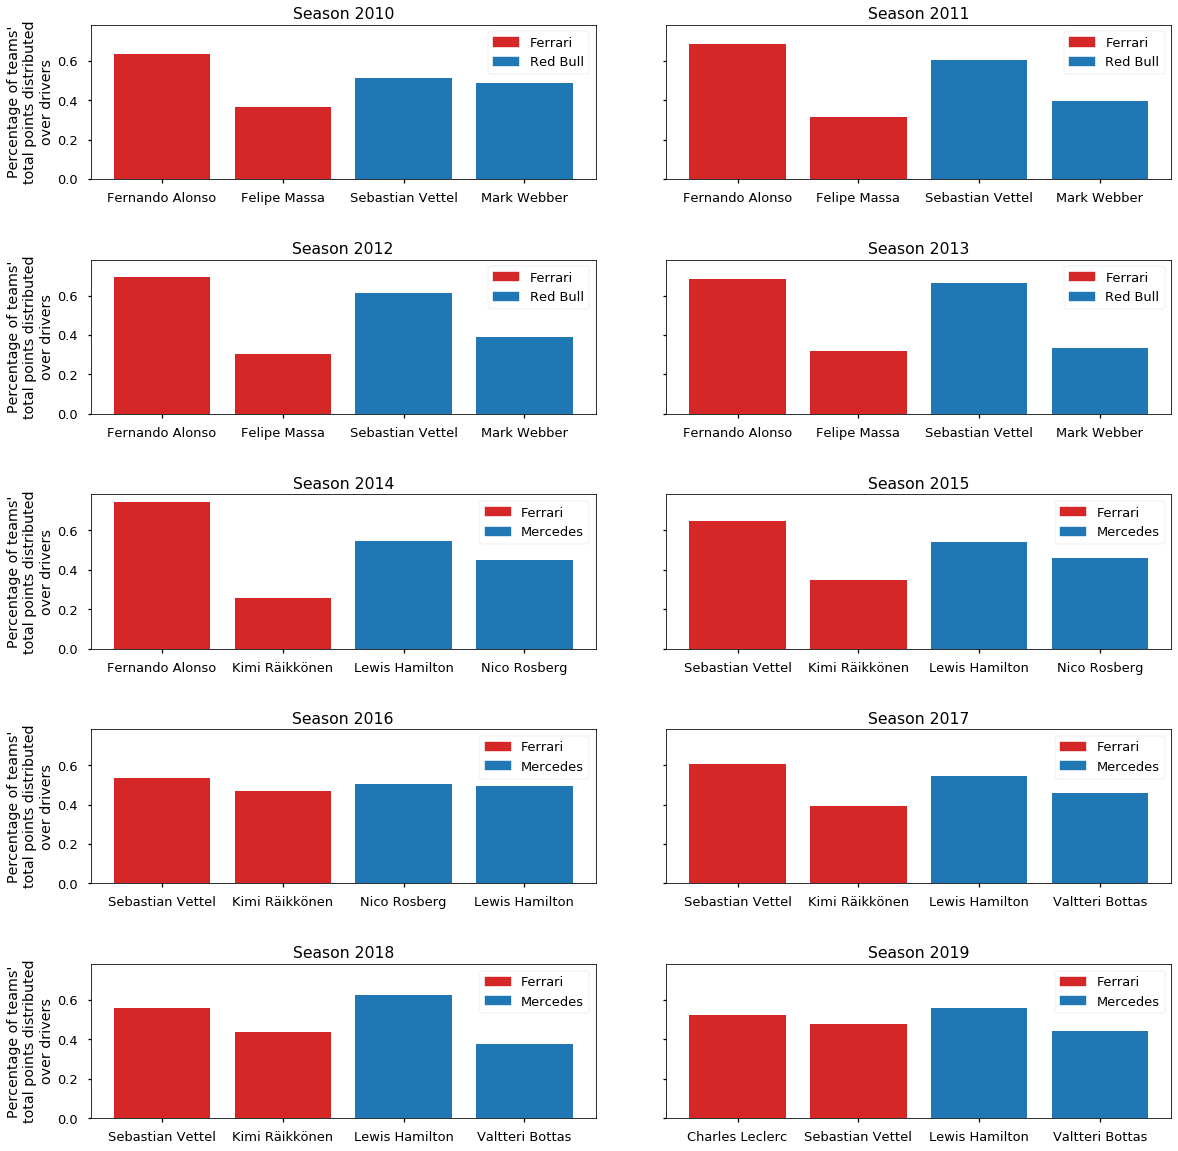

In [23]:
fig, ax = plt.subplots(figsize=(17,17), nrows=5, ncols=2, sharey=True)
fig.tight_layout(pad=5)
years = result.year.unique()
for ind in range(0,len(years),2):
    ax_ind = ind//2
    
    for add in range(2):

        year = years[ind+add]
        
        t1, t2 = result[result.year==year].team.unique()
        
        if t1 == "Ferrari":
            
            drivers, contrib = get_driver_contrib(t1, t2, year)
            
            red_patch = mpatches.Patch(color='tab:red', label=t1)
            blue_patch = mpatches.Patch(color='tab:blue', label=t2)
            
        else:
            
            drivers, contrib = get_driver_contrib(t2, t1, year)
                
            red_patch = mpatches.Patch(color='tab:red', label=t2)
            blue_patch = mpatches.Patch(color='tab:blue', label=t1)
            
        ax[ax_ind][add].bar(drivers, contrib, color=['tab:red','tab:red','tab:blue','tab:blue'])
        ax[ax_ind][add].set_title(f"Season {years[ind+add]}")
        
        ax[ax_ind][add].legend(handles=[red_patch, blue_patch])
        ax[ax_ind][add].grid(False)
        
    ax[ax_ind][0].set_ylabel("Percentage of teams'\ntotal points distributed\nover drivers");

In [24]:
query_statement = """
                select races.year, drivers.name,
                
                    (

                        case
                            when status.status like "Finish%" or status.status like "+%" then "Completed"
                            else status.status
                        end

                    ) as resultType
                
                from results
                
                join constructors
                    on constructors.constructorId = results.constructorId
                    
                join races
                    on races.raceId = results.raceId
                    
                join drivers
                    on drivers.driverId = results.driverId
                    
                join status
                    on status.statusId = results.statusId
                    
                where constructors.name = "Ferrari" and (races.year between 2015 and 2019) and resultType!="Completed"
                
                order by races.year
            """
result = read_sql_query(query_statement, conn)

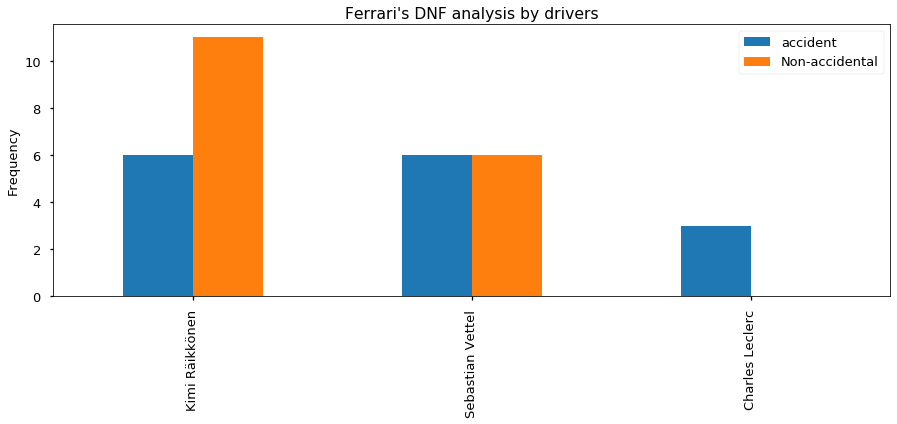

In [25]:
result.resultType = result.resultType.apply(lambda val: "Accident" if val=="Accident" or val=="Collision" or val=="Collision damage" else val)
result.resultType = result.resultType.apply(lambda val: "Non-accidental" if val!="Accident" else val)

non_accidental = []
accident = []
names = []

for driver in result.name.unique():
    driver_dict = result[result.name==driver].resultType.value_counts().to_dict()
    
    try:
        non_accidental.append(driver_dict["Non-accidental"])
    except:
        non_accidental.append(0)
    
    try:
        accident.append(driver_dict["Accident"])
    except:
        accident.append(0)
    
    names.append(driver)
    
fig, ax = plt.subplots(figsize=(15,5))
pd.DataFrame({"Name":names, "accident":accident, "Non-accidental":non_accidental}).plot(x="Name", kind="bar", ax=ax)
ax.set_xlabel("")
ax.set_ylabel("Frequency", fontsize=13)
ax.set_title("Ferrari's DNF analysis by drivers")
ax.grid(False);

In [26]:
query_statement = """
                    select races.year, constructors.name,
                    
                        (
                        
                            case
                                when results.grid in (1,2) then "first_row"
                                when results.grid in (3,4) then "second_row"
                                when results.grid in (5,6) then "third_row"
                                else "out_of_third_row" 
                            end
                        ) as gridType
                    
                    from results
                    
                    join constructors
                        on constructors.constructorId = results.constructorId
                        
                    join races
                        on races.raceId = results.raceId
                        
                    join
                    
                        (

                            select last_race.year, constructors.name as seasonWinner from constructor_standings

                            join

                                (

                                    select year, raceId from races
                                    where year between 2010 and 2019
                                    group by year
                                    having max(round)

                                ) as last_race

                                    on constructor_standings.raceId = last_race.raceId

                            join constructors
                                on constructors.constructorId = constructor_standings.constructorId

                            where constructor_standings.position=1


                        ) as season_winner
                        
                            on season_winner.year = races.year
                        
                    where (races.year between 2010 and 2019) and constructors.name in ("Ferrari", season_winner.seasonWinner)
            """
result = read_sql_query(query_statement, conn)

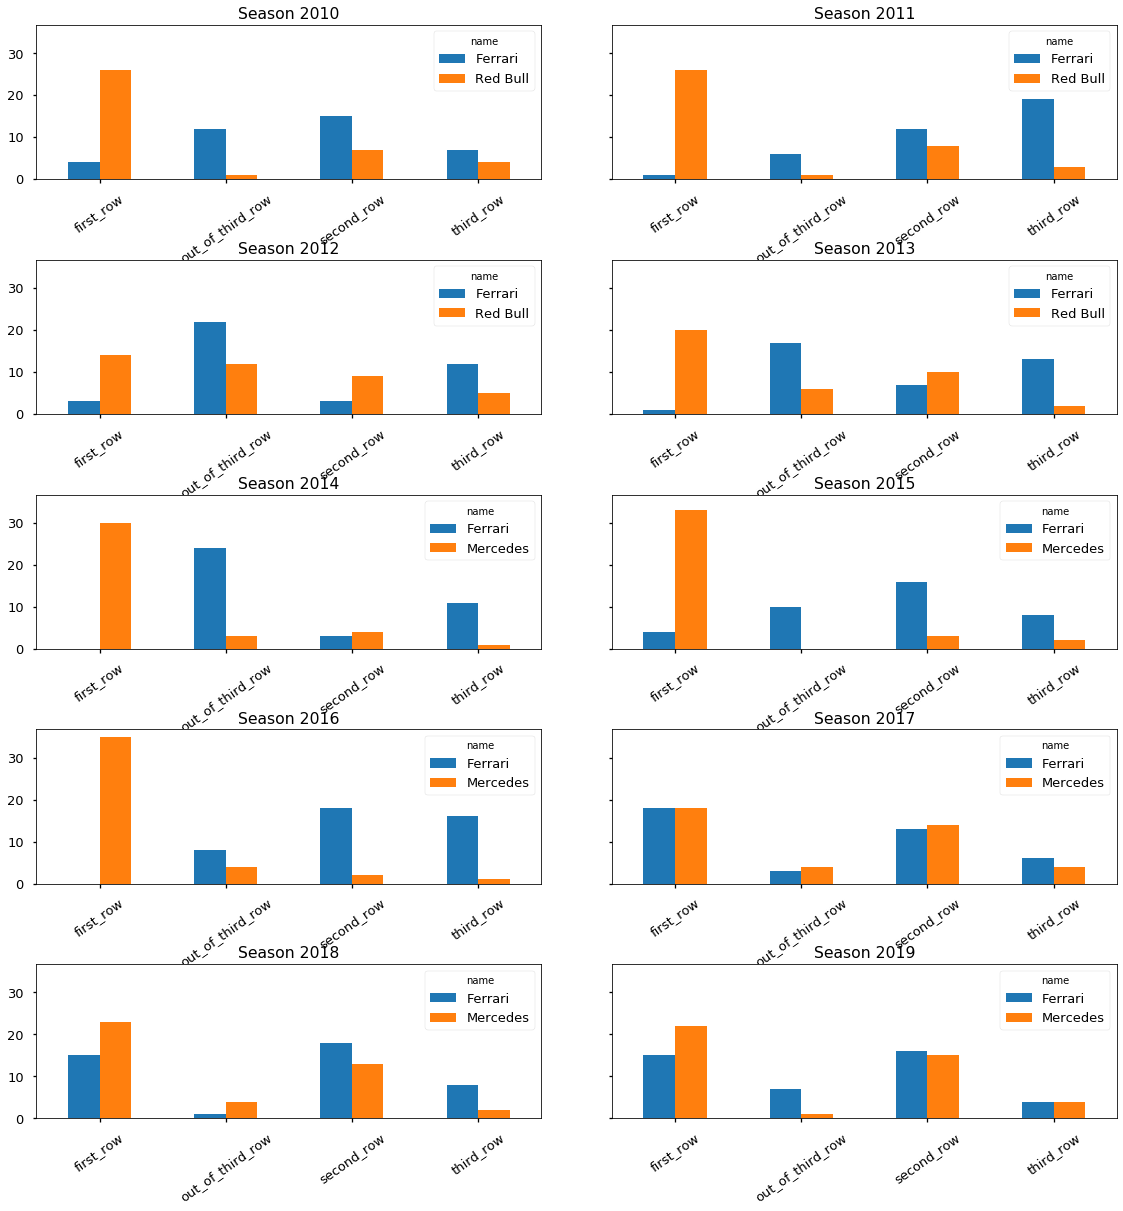

In [27]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(17,17), nrows=5, ncols=2, sharey=True)
fig.tight_layout(pad=5)
years = result.year.unique()
for ind in range(0,len(years),2):
    ax_ind = ind//2
    
    for add in range(2):
        year = years[ind+add]
        df = result[result.year==year].groupby("name").gridType.value_counts().to_frame()
        name = []
        gridType = []
        for team, cat in df.index:
            name.append(team)
            gridType.append(cat)
        df.index = range(df.shape[0])
        df.rename(columns={"gridType":"Counts"}, inplace=True)
        df["name"] = name
        df["gridType"] = gridType
        df.pivot(index='gridType', columns='name', values='Counts').plot(kind='bar', ax=ax[ax_ind][add], rot=35, xlabel="")
        ax[ax_ind][add].set_title(f"Season {years[ind+add]}")
        ax[ax_ind][add].grid(False);

In [28]:
query_statement = """
                    select races.year, constructors.name,
                    
                        sum(case
                                when results.grid>3 and results.position<4 then 1
                                else 0
                            end) as podiumGain,
            
                        sum(case
                                when results.grid>3 then 1
                                else 0
                            end) as noPodiumStart
        
                    from results
                    
                    join constructors
                        on constructors.constructorId = results.constructorId
                        
                    join races
                        on races.raceId = results.raceId
                        
                    join
                    
                        (

                            select last_race.year, constructors.name as seasonWinner from constructor_standings

                            join

                                (

                                    select year, raceId from races
                                    where year between 2010 and 2019
                                    group by year
                                    having max(round)

                                ) as last_race

                                    on constructor_standings.raceId = last_race.raceId

                            join constructors
                                on constructors.constructorId = constructor_standings.constructorId

                            where constructor_standings.position=1


                        ) as season_winner
                        
                            on season_winner.year = races.year

                        
                    where (races.year between 2010 and 2019) and constructors.name in ("Ferrari", season_winner.seasonWinner)
                    
                    group by races.year, constructors.name
            """
result = read_sql_query(query_statement, conn)

In [29]:
result["percent_podiumGain"] = result["podiumGain"]/result["noPodiumStart"]

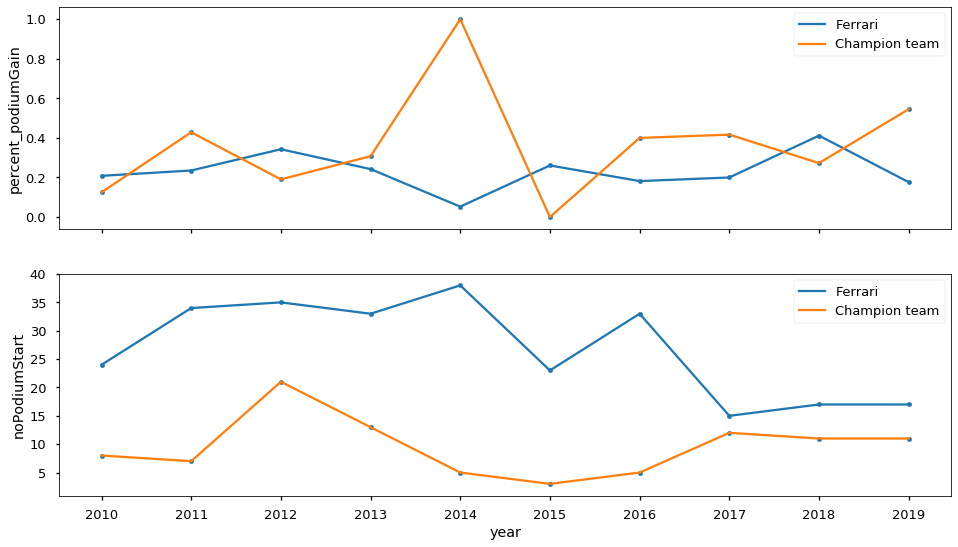

In [30]:
fig, [ax1, ax2] = plt.subplots(figsize=(16,9), nrows=2, ncols=1, sharex=True)

result[result.name=="Ferrari"][["year","percent_podiumGain"]].plot(kind="line", x="year",y="percent_podiumGain", ax=ax1)
result[result.name=="Ferrari"][["year","percent_podiumGain"]].plot(kind="scatter", x="year",y="percent_podiumGain", ax=ax1)

result[result.name!="Ferrari"][["year","percent_podiumGain"]].plot(kind="line", x="year",y="percent_podiumGain", ax=ax1)
result[result.name!="Ferrari"][["year","percent_podiumGain"]].plot(kind="scatter", x="year",y="percent_podiumGain", ax=ax1)

ax1.legend(["Ferrari","Champion team"])
ax1.grid(False)

result[result.name=="Ferrari"][["year","noPodiumStart"]].plot(kind="line", x="year",y="noPodiumStart", ax=ax2)
result[result.name=="Ferrari"][["year","noPodiumStart"]].plot(kind="scatter", x="year",y="noPodiumStart", ax=ax2)

result[result.name!="Ferrari"][["year","noPodiumStart"]].plot(kind="line", x="year",y="noPodiumStart", ax=ax2)
result[result.name!="Ferrari"][["year","noPodiumStart"]].plot(kind="scatter", x="year",y="noPodiumStart", ax=ax2)

ax2.set_xticks(result.year.unique())

ax2.legend(["Ferrari","Champion team"])
ax2.grid(False);

In [31]:
query_statement = """
                    select races.year, races.raceId, constructors.name team, drivers.name driver, sum(lap_times.milliseconds) total_lap_time, 
                    
                        (
                        
                            case
                                when status.status not like "Finish%" and status.status not like "+%" then 1
                                else 0
                            end
                        ) Retired
                    
                    from lap_times
                    
                    join results
                        on results.raceId = lap_times.raceId and results.driverId = lap_times.driverId
                    
                    join constructors
                        on constructors.constructorId = results.constructorId
                        
                    join drivers
                        on drivers.driverId = results.driverId
                        
                    join races
                        on races.raceId = results.raceId
                        
                    join status
                        on status.statusId = results.statusId
                        
                    join
                    
                        (

                            select last_race.year, constructors.name as seasonWinner from constructor_standings

                            join

                                (

                                    select year, raceId from races
                                    where year between 2010 and 2019
                                    group by year
                                    having max(round)

                                ) as last_race

                                    on constructor_standings.raceId = last_race.raceId

                            join constructors
                                on constructors.constructorId = constructor_standings.constructorId

                            where constructor_standings.position=1


                        ) as season_winner
                        
                            on season_winner.year = races.year
                        
                    where (races.year between 2011 and 2019) and constructors.name in ("Ferrari", season_winner.seasonWinner)
                    
                    group by races.year, races.raceId, drivers.name
            """
result_lap_time = read_sql_query(query_statement, conn)

query_statement = """
                    select races.year, races.raceId, constructors.name team, drivers.name driver, sum(pit_stops.milliseconds) total_pit_stop_time from pit_stops
                    
                    join results
                        on results.raceId = pit_stops.raceId and results.driverId = pit_stops.driverId
                    
                    join constructors
                        on constructors.constructorId = results.constructorId
                        
                    join drivers
                        on drivers.driverId = results.driverId
                        
                    join races
                        on races.raceId = results.raceId
                        
                    join
                    
                        (

                            select last_race.year, constructors.name as seasonWinner from constructor_standings

                            join

                                (

                                    select year, raceId from races
                                    where year between 2010 and 2019
                                    group by year
                                    having max(round)

                                ) as last_race

                                    on constructor_standings.raceId = last_race.raceId

                            join constructors
                                on constructors.constructorId = constructor_standings.constructorId

                            where constructor_standings.position=1


                        ) as season_winner
                        
                            on season_winner.year = races.year
                        
                    where (races.year between 2011 and 2019) and constructors.name in ("Ferrari", season_winner.seasonWinner)
                    
                    group by races.year, races.raceId, drivers.name
            """
result_pit_stop_time = read_sql_query(query_statement, conn)

In [32]:
df = pd.merge(result_lap_time, result_pit_stop_time, on=["year", "raceId", "team", "driver"], how="left")

df["total_pit_stop_time"].fillna(0, inplace=True)

df = df[df["Retired"] != 1]

df["net_lap_time"] = df["total_lap_time"] - df["total_pit_stop_time"]

years = df["year"].unique()
raceId = df["raceId"].unique()

year_diff = {}
for year in years:
    
    lap_time_diff = []    
    for race in raceId:
        
        df_temp = df[(df["year"] == year) & (df["raceId"] == race)].reset_index(drop=True)
        n_rows = df_temp.shape[0]
        teams = df_temp["team"].unique()
        n_teams = len(teams)
        
        if n_rows in [0, 1]:
            continue
            
        elif n_rows == 2:
            if n_teams == 1:
                continue
            else:
                win_team_lap_time = df_temp[df_temp["team"] == win_team]["net_lap_time"].values[0]
                ferrari_lap_time = df_temp[df_temp["team"] == "Ferrari"]["net_lap_time"].values[0]
                
                val = win_team_lap_time - ferrari_lap_time
            
        elif n_rows == 3:
            win_team = [val for val in teams if val!="Ferrari"][0]
            win_team_cnt = df_temp[df_temp["team"] == win_team].shape[0]
            ferrari_cnt = df_temp[df_temp["team"] == "Ferrari"].shape[0]
            
            if ferrari_cnt > win_team_cnt:
                win_team_lap_time = df_temp[df_temp["team"] == win_team]["net_lap_time"].values[0]
                ferrari_lap_time = np.min(df_temp[df_temp["team"] == "Ferrari"]["net_lap_time"].values)
            
            else:
                win_team_lap_time = np.min(df_temp[df_temp["team"] == win_team]["net_lap_time"].values)
                ferrari_lap_time = df_temp[df_temp["team"] == "Ferrari"]["net_lap_time"].values[0]
                
            val = win_team_lap_time - ferrari_lap_time
            
        else:
            win_team = [val for val in teams if val!="Ferrari"][0]
            win_team_lap_time = np.sum(df_temp[df_temp["team"] == win_team]["net_lap_time"].values)
            ferrari_lap_time = np.sum(df_temp[df_temp["team"] == "Ferrari"]["net_lap_time"].values)
            
            val = win_team_lap_time - ferrari_lap_time
            
        lap_time_diff.append(val/1000)
        
    year_diff[year] = lap_time_diff


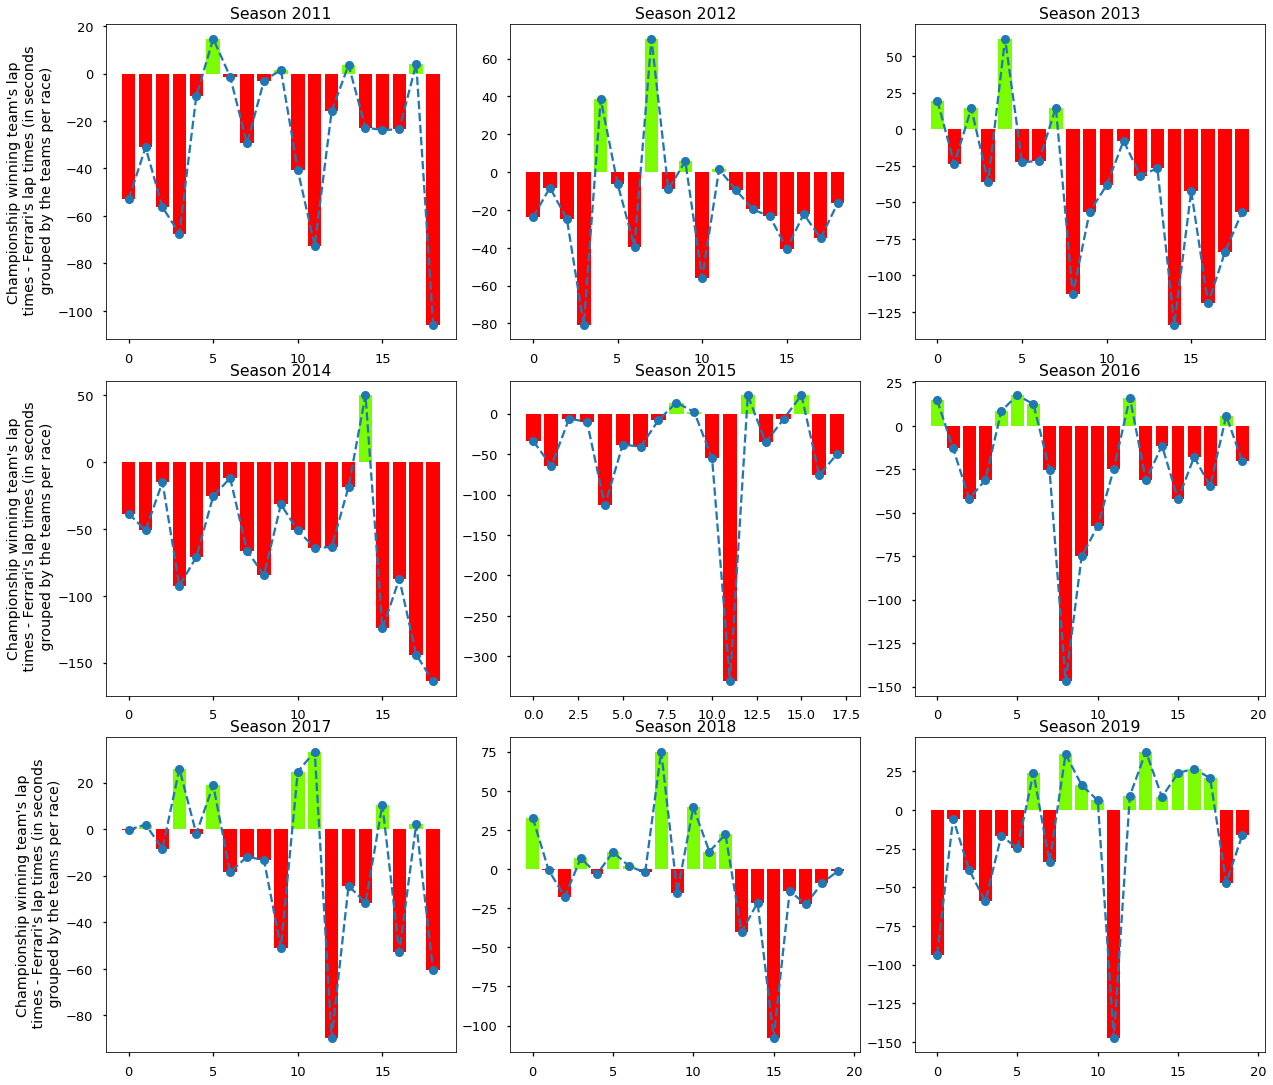

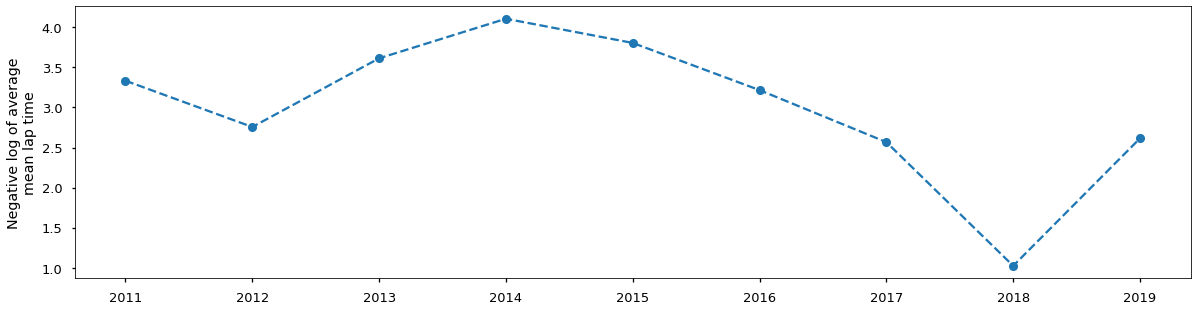

In [33]:
fig, ax0 = plt.subplots(figsize=(17,15), nrows=3, ncols=3)
fig.tight_layout()

year_mean_diff = {}

for ind in range(0,len(years)-1,3):
    ax_ind = ind//3
    
    for add in range(3):
        year = years[ind+add]
        year_vals = year_diff[year]
        colors=['red' if val<0 else 'lawngreen' for val in year_vals]
        ax0[ax_ind][add].plot(year_vals, "--o")
        ax0[ax_ind][add].bar(range(len(year_vals)), year_vals, color=colors)
        ax0[ax_ind][add].set_title(f"Season {year}")
        ax0[ax_ind][add].grid(False)
        
        year_mean_diff[year] = np.log(-1*np.mean(year_vals))
        
        if add!=0:
            continue
            
        ax0[ax_ind][add].set_ylabel("Championship winning team's lap\n times - Ferrari's lap times (in seconds\n grouped by the teams per race)")
        
fig, ax1 = plt.subplots(figsize=(20,5))
ax1.plot(list(year_mean_diff.keys()), list(year_mean_diff.values()), "--o")
ax1.set_ylabel("Negative log of average\nmean lap time");